In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 27 mile width
# 34 mile length
xvals = np.arange(0, 26)
yvals = np.arange(0, 22)

xx, yy = np.meshgrid(xvals, yvals)

In [3]:
xx = xx * 27
yy = yy * 34

In [4]:
points = np.array([xx, yy])
points = np.reshape(np.reshape(points, 22*26*2, order = 'F'), [22*26, 2])

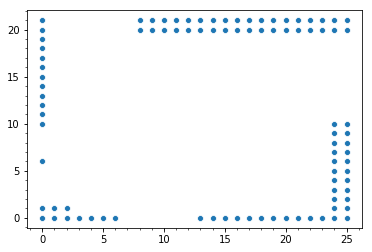

In [5]:
# delete points that are not in states.  y values multiplied by 34, x by 27.
# first column delPoints
delPoints = list(range(2)) + list(range(6, 7)) + list(range(10,22))
# 2nd / 3rd column delPoints
delPoints = delPoints + [x+22 for x in list(range(2))] + 
            [x+44 for x in list(range(2))]
# 4th through 7th column delPoints
delPoints = delPoints + [x*22 for x in list(range(3, 7))]
# highest row past tip of Utah
delPoints = delPoints + [x*22 + 21 for x in range(8, 26)]
# 2nd highest row past tip of Utah
delPoints = delPoints + [x*22 + 20 for x in range(8, 26)] 

delPoints = delPoints + [x*22 for x in range(13, 26)]   # rest of bottom row
delPoints = delPoints + [24*22 + x for x in range(1, 11)]  # second to last col
delPoints = delPoints + [25*22 + x for x in range(1, 11)]  # last col

# print(delPoints)  # print row indexes of points you are deleting

# plot points you are deleting
# create plot, scaled back down.
ax = sns.scatterplot(points[delPoints,0] / 27, y=points[delPoints,1] / 34) 
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))  # set minor y tics
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))  # set minor x tics
ax   # display plot

# deleting points in delPoints.
points = np.delete(points, delPoints, axis=0)

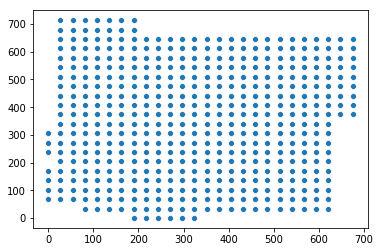

In [6]:
ax = sns.scatterplot(x=points[:,0], y=points[:,1])
ax

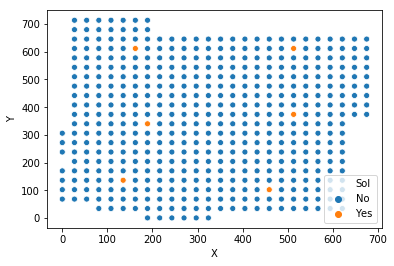

In [7]:
XSol200 = [92, 127, 141, 384, 331, 377]  # REMEMBER TO MINUS ONE FROM AMPL SOL
#plt.show(sns.scatterplot(x = points[XSol200, 0], y = points[XSol200, 1]))

pointsData = pd.DataFrame(points, columns = ['X','Y'])
pointsData['Sol'] = 'No'
pointsData.iloc[XSol200, 2] = 'Yes'

ax = sns.scatterplot(x='X', y='Y', hue='Sol', data = pointsData)
ax

In [8]:
points.shape

(480, 2)

In [9]:
spd = np.zeros((480, 480))
count1 = -1
count2 = 0
for p1 in points:
    count1 += 1
    count2 = 0
    for p2 in points:
        dist = np.linalg.norm(p1 - p2)
        spd[count1, count2] = dist
        count2 += 1

In [10]:
spd.shape

(480, 480)

In [11]:
#np.savetxt('spd.txt', spd, fmt = '%.4f', delimiter = ' ')

In [12]:
# making F matrix
numNodes = spd.shape[0]
rowIndex= -1

F = np.zeros(( int(.5 * (numNodes * (numNodes - 1))), numNodes ))

for u in range(numNodes-1):
    for v in range(u+1, numNodes):
        rowIndex += 1
        for j in range(numNodes):
            if spd[u, j] != spd[v, j]:
                F[rowIndex, j] = 1
            else:
                F[rowIndex, j] = 0

In [13]:
F.shape

(114960, 480)

In [14]:
# adding row/ col indexes to F matrix
numNodes = spd.shape[0]
rowIndex= -1

F = np.zeros(( int(.5 * (numNodes * (numNodes - 1))), numNodes ))
row_names = []
col_names = range(1, numNodes + 1)

for u in range(numNodes-1):
    for v in range(u+1, numNodes):
        row_names = row_names + [(u+1, v+1)]
        rowIndex += 1
        for j in range(numNodes):
            if spd[u, j] != spd[v, j]:
                F[rowIndex, j] = 1
            else:
                F[rowIndex, j] = 0

In [15]:
row_names = range(1, F.shape[0]+1)
FData = pd.DataFrame(F, columns = col_names, index = row_names)
#FData.to_csv('FDataFrameNums.txt', sep = ' ')